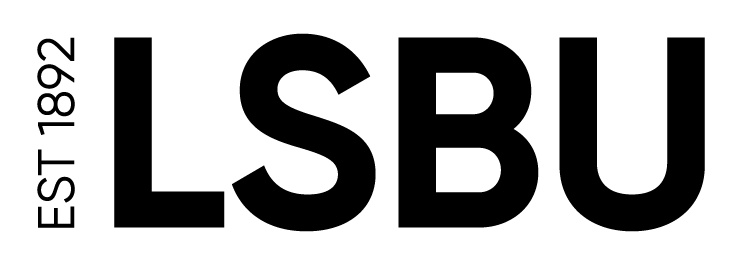

## Introduction
This notebook shows how to retrieve text messages sent by students to a Twilio number for a specific time duration to create an attendance based on the course date time data available on course datasets stored in .csv files.

## Objectives
-  Create academic timetable based on the academic year
-  Data Engineering with time series data

In [1]:
# Import libraries
import os
import pathlib
import secrets
from dotenv import load_dotenv
import pandas as pd
from datetime import date
from twilio.rest import Client
from flask import Flask
from flask_mail import Mail, Message

In [2]:
# Set paths
base_dir = pathlib.Path().absolute().parent
# Path to all data directories
data = base_dir/'datasets'

# Path to credentials data
credentials = data/'credentials'

# Path to state data
state = data/'state'

# Path to raw data
raw = data/'raw'

# Path to processed data
processed = data/'processed'

# Path to environment variables
env_vars = pathlib.Path(base_dir/'env_vars')

In [3]:
# Academic years for current and next academic year
years =  [str(date.today().year-1)+'-'+str(date.today().year)[2:], str(date.today().year)+'-'+str(date.today().year+1)[2:]]
years

['2022-23', '2023-24']

In [4]:
# Academic years dictionary (for current and next academic year)
year_dict = {str(date.today().year-1)+'-'+str(date.today().year)[2:]: [date.today().year-1, date.today().year], str(date.today().year)+'-'+str(date.today().year+1)[2:]: [date.today().year, date.today().year+1]}
year_dict

{'2022-23': [2022, 2023], '2023-24': [2023, 2024]}

In [5]:
# Year 1 in current academic year
year_1 = year_dict['2022-23'][0]
year_1

2022

In [6]:
# Year 2 in current academic year
year_2 = year_dict['2022-23'][1]
year_2

2023

In [7]:
# Date variables
total_academcic_week = 13
sem1_start = '2022-09-26' #YYYY-MM-DD
sem2_start = '2023-01-23' #YYYY-MM-DD
number_of_holiday_week1 = 2  # semester 1 holiday week
number_of_holiday_week2 = 3  # semester 2 holiday week
sem1_holiday_start = '2022-12-19' #YYYY-MM-DD
sem2_holiday_start = '2023-04-03' #YYYY-MM-DD

In [8]:
# Academic Calendar from 'September' to 'June' next year
df_date = pd.DataFrame(pd.period_range(start=date(year_1, 9, 1), end=date(year_2, 6, 30), freq='W'), columns=['date_range'])
df_date['month'] = df_date.date_range.dt.start_time.dt.month_name()
df_date

,date_range,month
0,2022-08-29/2022-09-04,August
1,2022-09-05/2022-09-11,September
2,2022-09-12/2022-09-18,September
3,2022-09-19/2022-09-25,September
4,2022-09-26/2022-10-02,September
5,2022-10-03/2022-10-09,October
6,2022-10-10/2022-10-16,October
7,2022-10-17/2022-10-23,October
8,2022-10-24/2022-10-30,October
9,2022-10-31/2022-11-06,October


In [9]:
# Calendar from semester 1 start date
df1 = df_date.loc[df_date[df_date.date_range.dt.start_time.dt.date.astype(str) == sem1_start].index.values[0]:, ['date_range']].reset_index(drop=True)
df1

,date_range
0,2022-09-26/2022-10-02
1,2022-10-03/2022-10-09
2,2022-10-10/2022-10-16
3,2022-10-17/2022-10-23
4,2022-10-24/2022-10-30
5,2022-10-31/2022-11-06
6,2022-11-07/2022-11-13
7,2022-11-14/2022-11-20
8,2022-11-21/2022-11-27
9,2022-11-28/2022-12-04


In [10]:
# Calendar from semester 2 start date
df2 = df_date.loc[df_date[df_date.date_range.dt.start_time.dt.date.astype(str) == sem2_start].index.values[0]:, ['date_range']].reset_index(drop=True)
df2

,date_range
0,2023-01-23/2023-01-29
1,2023-01-30/2023-02-05
2,2023-02-06/2023-02-12
3,2023-02-13/2023-02-19
4,2023-02-20/2023-02-26
5,2023-02-27/2023-03-05
6,2023-03-06/2023-03-12
7,2023-03-13/2023-03-19
8,2023-03-20/2023-03-26
9,2023-03-27/2023-04-02


In [11]:
# Last academic weeks before holiday for each semester
last_academic_week1 = df1[df1.date_range.dt.start_time.dt.date.astype(str) == sem1_holiday_start].index.values[0]
last_academic_week2 = df2[df2.date_range.dt.start_time.dt.date.astype(str) == sem2_holiday_start].index.values[0]
last_academic_week1, last_academic_week2

(12, 10)

In [12]:
# Semester 1 academic calendar
df1 = pd.concat([df1.loc[:last_academic_week1-1], df1.loc[last_academic_week1+number_of_holiday_week1:]]).reset_index(drop=True).loc[:total_academcic_week-1]
df1

,date_range
0,2022-09-26/2022-10-02
1,2022-10-03/2022-10-09
2,2022-10-10/2022-10-16
3,2022-10-17/2022-10-23
4,2022-10-24/2022-10-30
5,2022-10-31/2022-11-06
6,2022-11-07/2022-11-13
7,2022-11-14/2022-11-20
8,2022-11-21/2022-11-27
9,2022-11-28/2022-12-04


In [13]:
# Semester 2 academic calendar
df2 = pd.concat([df2.loc[:last_academic_week2-1], df2.loc[last_academic_week2+number_of_holiday_week2:]]).reset_index(drop=True).loc[:total_academcic_week-1]
df2

,date_range
0,2023-01-23/2023-01-29
1,2023-01-30/2023-02-05
2,2023-02-06/2023-02-12
3,2023-02-13/2023-02-19
4,2023-02-20/2023-02-26
5,2023-02-27/2023-03-05
6,2023-03-06/2023-03-12
7,2023-03-13/2023-03-19
8,2023-03-20/2023-03-26
9,2023-03-27/2023-04-02


In [14]:
# Semester 1 academic calendar
# Add additional features
df1['academic_semester'] = 1
df1['academic_week'] = df1.index+1
df1['calendar_week'] = df1.date_range.dt.start_time.dt.week
df1['week_start'] = df1.date_range.dt.start_time.dt.date
df1['week_end'] = df1.date_range.dt.end_time.dt.date

# Rearrange
df1 = df1[['academic_semester', 'academic_week', 'calendar_week', 'date_range', 'week_start', 'week_end']]

# Preview
df1

C:\Users\ahmedk40\Miniconda3\envs\twilio\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


,academic_semester,academic_week,calendar_week,date_range,week_start,week_end
0,1,1,39,2022-09-26/2022-10-02,2022-09-26,2022-10-02
1,1,2,40,2022-10-03/2022-10-09,2022-10-03,2022-10-09
2,1,3,41,2022-10-10/2022-10-16,2022-10-10,2022-10-16
3,1,4,42,2022-10-17/2022-10-23,2022-10-17,2022-10-23
4,1,5,43,2022-10-24/2022-10-30,2022-10-24,2022-10-30
5,1,6,44,2022-10-31/2022-11-06,2022-10-31,2022-11-06
6,1,7,45,2022-11-07/2022-11-13,2022-11-07,2022-11-13
7,1,8,46,2022-11-14/2022-11-20,2022-11-14,2022-11-20
8,1,9,47,2022-11-21/2022-11-27,2022-11-21,2022-11-27
9,1,10,48,2022-11-28/2022-12-04,2022-11-28,2022-12-04


In [15]:
# Semester 2 academic calendar
# Add additional features
df2['academic_semester'] = 2
df2['academic_week'] = df2.index+1
df2['calendar_week'] = df2.date_range.dt.start_time.dt.week
df2['week_start'] = df2.date_range.dt.start_time.dt.date
df2['week_end'] = df2.date_range.dt.end_time.dt.date

# Rearrange
df2 = df2[['academic_semester', 'academic_week', 'calendar_week', 'date_range', 'week_start', 'week_end']]

# Preview
df2

C:\Users\ahmedk40\Miniconda3\envs\twilio\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


,academic_semester,academic_week,calendar_week,date_range,week_start,week_end
0,2,1,4,2023-01-23/2023-01-29,2023-01-23,2023-01-29
1,2,2,5,2023-01-30/2023-02-05,2023-01-30,2023-02-05
2,2,3,6,2023-02-06/2023-02-12,2023-02-06,2023-02-12
3,2,4,7,2023-02-13/2023-02-19,2023-02-13,2023-02-19
4,2,5,8,2023-02-20/2023-02-26,2023-02-20,2023-02-26
5,2,6,9,2023-02-27/2023-03-05,2023-02-27,2023-03-05
6,2,7,10,2023-03-06/2023-03-12,2023-03-06,2023-03-12
7,2,8,11,2023-03-13/2023-03-19,2023-03-13,2023-03-19
8,2,9,12,2023-03-20/2023-03-26,2023-03-20,2023-03-26
9,2,10,13,2023-03-27/2023-04-02,2023-03-27,2023-04-02


In [16]:
# Concatenate semester 1 and 2 calendar
# Academic year calendar
df = pd.concat([df1, df2], ignore_index=True)
# Preview
df

,academic_semester,academic_week,calendar_week,date_range,week_start,week_end
0,1,1,39,2022-09-26/2022-10-02,2022-09-26,2022-10-02
1,1,2,40,2022-10-03/2022-10-09,2022-10-03,2022-10-09
2,1,3,41,2022-10-10/2022-10-16,2022-10-10,2022-10-16
3,1,4,42,2022-10-17/2022-10-23,2022-10-17,2022-10-23
4,1,5,43,2022-10-24/2022-10-30,2022-10-24,2022-10-30
5,1,6,44,2022-10-31/2022-11-06,2022-10-31,2022-11-06
6,1,7,45,2022-11-07/2022-11-13,2022-11-07,2022-11-13
7,1,8,46,2022-11-14/2022-11-20,2022-11-14,2022-11-20
8,1,9,47,2022-11-21/2022-11-27,2022-11-21,2022-11-27
9,1,10,48,2022-11-28/2022-12-04,2022-11-28,2022-12-04


In [17]:
# Export Academic year calender
# df.to_csv(credentials/f'timetable.csv', index=False)

### Summary
In this notebook it was demonstrated how to:
-  Create academic timetable based on the academic year
-  Data Engineering with time series data

<center><b>Author</b></center>

| Name | Date Created | Last Modified |
|------|--------------|---------------|
|Khaled Ahmed | 20/01/2023 | 04/02/2023|